## Classify card hands using an Encoder layer

In this notebook we classify whether a hand of playing cards is sorted or not. The sorted order uses suit as the primary key: Diamonds, Clubs, Hearts, Spades. The secondary key is the value of the card: 2, 3, 4, 5, 6, 7, 8, 9, 10, Jack, Queen, King, Ace. This gives a vocabulary of size 52. We train two versions, 
one that embeds the integer index of the card, another that embeds the image of the card, using 
a convolutional network. Currently the CNN isn't working, and needs to be debugged.


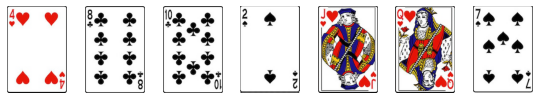

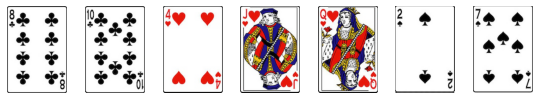

In [1]:
#!pip install pydealer
from hand2hand import Cards
import pydealer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

deck = Cards()
pydeck = pydealer.Deck()
pydeck.shuffle()
hand = pydeck.deal(7)
deck.show_pyhand(hand)
deck.sort_pyhand(hand)
deck.show_pyhand(hand)


(178, 122, 3)

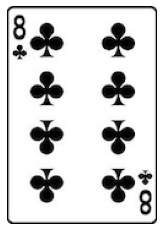

In [2]:
img = deck.image_of_pycard(hand[0])
plt.imshow(img)
plt.axis('off')
img.shape



We'll use an `Encoder` to represent the sequence, and then train a logistic regression model on top of this to do the classification. The whole thing is trained end-to-end. The `Encoder` uses a series of `EncoderLayer` modules, which first embeds the sequence with embedding and positional encoding, and then makes a series of transformations that compose multihead attention with feedforward layers (with normalization in between). The code below implements a classifier on top of this.

Two versions are coded below, one that uses an embedding of integers, another that uses an embedding of the card image. One thing to note is the following code:

```python
  y = tf.reshape(x, (shape[0]*shape[1], shape[-3], shape[-2], shape[-1]))
  y = self.cnn(y)
  y = tf.reshape(y, (shape[0], shape[1], self.d_model))
  y *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
  y = y + self.pos_encoding[tf.newaxis, :length, :]
```

This is my solution to use a CNN embedder. The data come in as a tensor of shape `(None, 7, 178, 122, 3)`, where the first index is the batch size. In order to apply the CNN to each image in this tensor I reshape it as `(B*7, 178, 122, 3)` where `B` is the batch size. The result is a tensor of shape `(B*7, d_model)` which is then reshaped to `(B, 7, d_model)` before adding in the positional encoding. This could host a bug :-)

In [3]:
import tensorflow as tf
import seq2seq_transformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Sequential
from seq2seq_transformer import Encoder, EncoderLayer, positional_encoding

In [4]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

class PositionalCNNEmbedding(tf.keras.layers.Layer):
  def __init__(self, d_model, img_shape=(178, 122, 3), ff_dim=32):
    super().__init__()
    self.d_model = d_model
    img_input = layers.Input(shape=img_shape)
    x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
    x = layers.MaxPooling2D((4,4))(x)
    x = layers.Conv2D(32, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((4,4))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(ff_dim, activation='relu')(x)
    outputs = layers.Dense(d_model, activation='tanh')(x)
    self.cnn = Model(inputs=img_input, outputs=outputs)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def call(self, x):
    shape = tf.shape(x)
    length = shape[1]
    y = tf.reshape(x, (shape[0]*shape[1], shape[-3], shape[-2], shape[-1]))
    y = self.cnn(y)
    y = tf.reshape(y, (shape[0], shape[1], self.d_model))
    # This factor sets the relative scale of the embedding and positonal_encoding.
    y *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    y = y + self.pos_encoding[tf.newaxis, :length, :]
    return y


class CNNEncoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, img_shape, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalCNNEmbedding(
        img_shape=img_shape, d_model=d_model, ff_dim=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`


In [5]:
class HandClassifier():
    def __init__(self, n, vocab_size=52, embed_dim=32, num_layers=4, num_heads=8, ff_dim1=128, ff_dim2=32):
        vocab_size=52
        self.embed_dim = embed_dim
        attr_input = layers.Input(shape=(n,))
        x = Encoder(num_layers=num_layers, d_model=embed_dim, vocab_size=vocab_size, num_heads=num_heads, dff=ff_dim1)(attr_input)
        model_out = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(ff_dim2, activation='relu')(model_out) 
        outputs = layers.Dense(2, activation='softmax')(x)
        self.model = Model(inputs=attr_input, outputs=outputs)
        self.model.summary()
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train, epochs=10):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=128, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test)
        return out

class HandCNNClassifier():
    def __init__(self, n, img_shape=(178, 122, 3), embed_dim=32, num_layers=4, num_heads=8, ff_dim1=128, ff_dim2=32):
        vocab_size=52
        self.embed_dim = embed_dim
        attr_input = layers.Input(shape=(n, 178, 122, 3))
        x = CNNEncoder(num_layers=num_layers, d_model=embed_dim, img_shape=(178, 122, 3), num_heads=num_heads, dff=ff_dim1)(attr_input)
        model_out = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(ff_dim2, activation='relu')(model_out) 
        outputs = layers.Dense(2, activation='softmax')(x)
        self.model = Model(inputs=attr_input, outputs=outputs)
        self.model.summary()
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train, epochs=10):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test)
        return out


In [6]:
hc = HandClassifier(7, num_layers=1, num_heads=4)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 encoder (Encoder)           (None, 7, 32)             26944     
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 28,066
Trainable params: 28,066
Non-trainable params: 0
_________________________________________________________

### Prepare the data

Now we make a set of training/test data, by generating random 7-card hands, and sorting about half of them. 
The labels are whether or not the hand is sorted.

In [7]:
n = 10000
hand_size = 7
X = np.array((n*hand_size)*[0]).reshape(n, hand_size)
y = np.array(n*[0])

for i in np.arange(n):
    hand = pydeck.deal(hand_size)
    if len(hand) < hand_size:
        # ran out of cards, make a new deck
        pydeck = pydealer.Deck()
        pydeck.shuffle()
        hand = pydeck.deal(hand_size)
    if np.random.normal() < 0:
        deck.sort_pyhand(hand)
    X[i,:] = deck.index_pyhand(hand)
    y[i] = deck.is_sorted_pyhand(hand)



Now train and test the model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
hc.train(X_train, y_train, epochs=5)

Epoch 1/5
59/59 [==============================] - 3s 10ms/step - loss: 0.6799 - accuracy: 0.5564
Epoch 2/5
59/59 [==============================] - 1s 10ms/step - loss: 0.2331 - accuracy: 0.9285
Epoch 3/5
59/59 [==============================] - 1s 10ms/step - loss: 0.0919 - accuracy: 0.9696
Epoch 4/5
59/59 [==============================] - 1s 10ms/step - loss: 0.0577 - accuracy: 0.9811
Epoch 5/5
59/59 [==============================] - 1s 13ms/step - loss: 0.0389 - accuracy: 0.9860


In [9]:

out = hc.predict(X_test)
yhat_test = np.argmax(out, axis=1)
print('accuracy: %.2f%%' % (100*np.sum(yhat_test == y_test)/len(y_test)))

79/79 [==============================] - 1s 6ms/step
accuracy: 99.08%


Now create a version of the data set with card indices replaced by card images. 

In [10]:
n = 10000
hand_size = 7
X_img = np.zeros((n, hand_size, 178, 122, 3), dtype=int)
y_img = np.zeros(n, dtype=int)

deck = Cards()
pydeck = pydealer.Deck()
pydeck.shuffle()

for i in np.arange(n):
    hand = pydeck.deal(hand_size)
    if len(hand) < hand_size:
        # ran out of cards, make a new deck
        pydeck = pydealer.Deck()
        pydeck.shuffle()
        hand = pydeck.deal(hand_size)
    if np.random.normal() < 0:
        deck.sort_pyhand(hand)
    X_img[i,:] = np.array([deck.image_of_pycard(hand[j]) for j in range(hand_size)])
    y_img[i] = deck.is_sorted_pyhand(hand)



sorted=1


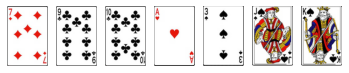

In [11]:
i = 42
fig, axarr = plt.subplots(1,7)
for j in range(7):
    axarr[j].imshow(X_img[i,j]); axarr[j].axis('off')
print('sorted=%d' % y_img[i])


In [12]:
hcc = HandCNNClassifier(n=7, num_layers=2, num_heads=4)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 178, 122, 3)]  0         
                                                                 
 cnn_encoder (CNNEncoder)    (None, 7, 32)             135008    
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 136,130
Trainable params: 136,130
Non-trainable params: 0
_____________________________________________________

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_img, y_img, test_size=0.25)
hcc.train(X_train, y_train, epochs=3)